# Predicción de costos medicos

Un modelo de regresion contruido para predecir los costos medicos de los pacientes

**ACERCA DE LOS DATOS**

Fueron recolectados de kaggle: https://www.kaggle.com/datasets/mirichoi0218/insurance

**CONTEXTO**

La Oficina del Censo de los Estados Unidos (USCB), oficialmente conocida como la Oficina del Censo, es una agencia principal del Sistema Estadístico Federal de EE. UU., encargada de producir datos sobre la gente y la economía de Estados Unidos. La Oficina del Censo es parte del Departamento de Comercio de EE. UU. y su director es nombrado por el Presidente de los Estados Unidos.

**CONTENIDO**

* age: edad del beneficiario principal
* sex: género del contratante de seguro, femenino, masculino
* imc: Índice de masa corporal, proporciona una comprensión del peso del cuerpo en relación con la altura, índice objetivo de peso corporal (kg/m^2) utilizando la relación de altura y peso, idealmente de 18.5 a 24.9
* children: número de niños cubiertos por el seguro de salud / número de dependientes
* smoker: fumar
* region: área de residencia del beneficiario en los EE.UU, noreste, sureste, suroeste, noroeste.
* charges: costos médicos individuales facturados por el seguro de salud.

 **PROPOSITO**
 
Nuestro propostio es analizar la relación entre las caracteristicas de los pacientes como la edad o si fuman o no con los costos y generar un modelo capaz de predecedir estos costos según las caracteristicas



## Importación de librerías y carga de datos

In [76]:
# Manipulación de datos
import pandas as pd
import numpy as np 
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
#Modelado
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#Metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# reporte estadistico
import statsmodels.api as sm

In [2]:
data_c=pd.read_csv('insurance.csv')

## Procesar los datos

In [3]:
data_c.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Se puede observar que no se presentan datos nulos pero si hay un dato duplicado el cual procedemos a eliminar

In [4]:
data_c.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
data_c[data_c.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Se hace una copia del dataset para trabajar los cambios en esta

In [5]:
data = data_c.copy()

In [6]:
data.drop_duplicates(inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


Podemos ver que tenemos 3 datos categoricos y 4 numericos

In [26]:
#Se obtiene las columnas categoricas y numericas para trabajar más facil con ellas>
cat= data.select_dtypes(include=object).columns.to_list()
num= data.select_dtypes(exclude=object).columns.to_list()

Para los datos categoricos se procede a crear histogramas para ver la distribucion

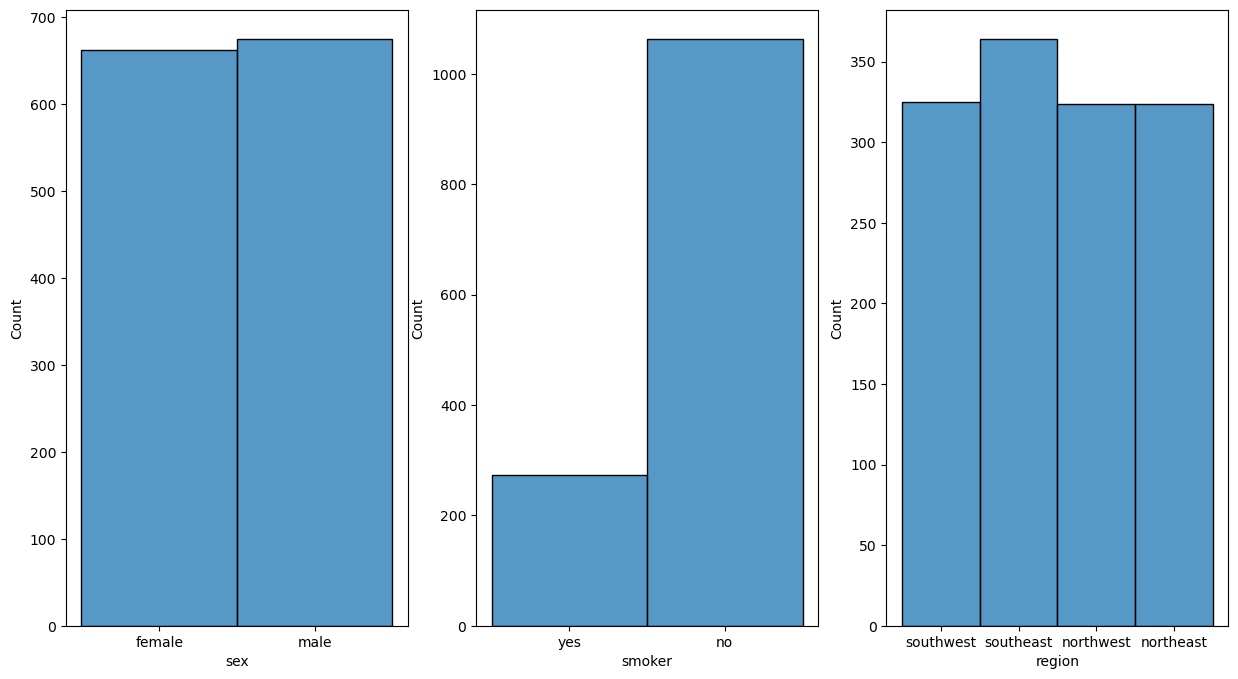

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
i = 0
for c in cat :
    sns.histplot(
        data= data, 
        x = data[c],
        ax=ax[i]
    )
    i += 1

Se puede observar que para las categorias 'sex' y 'region' los datos estan distribuidos de manera equitativa, mientras que para que la categoria 'smoker' se presenta una concentración de datos en la etiqueta 'no'

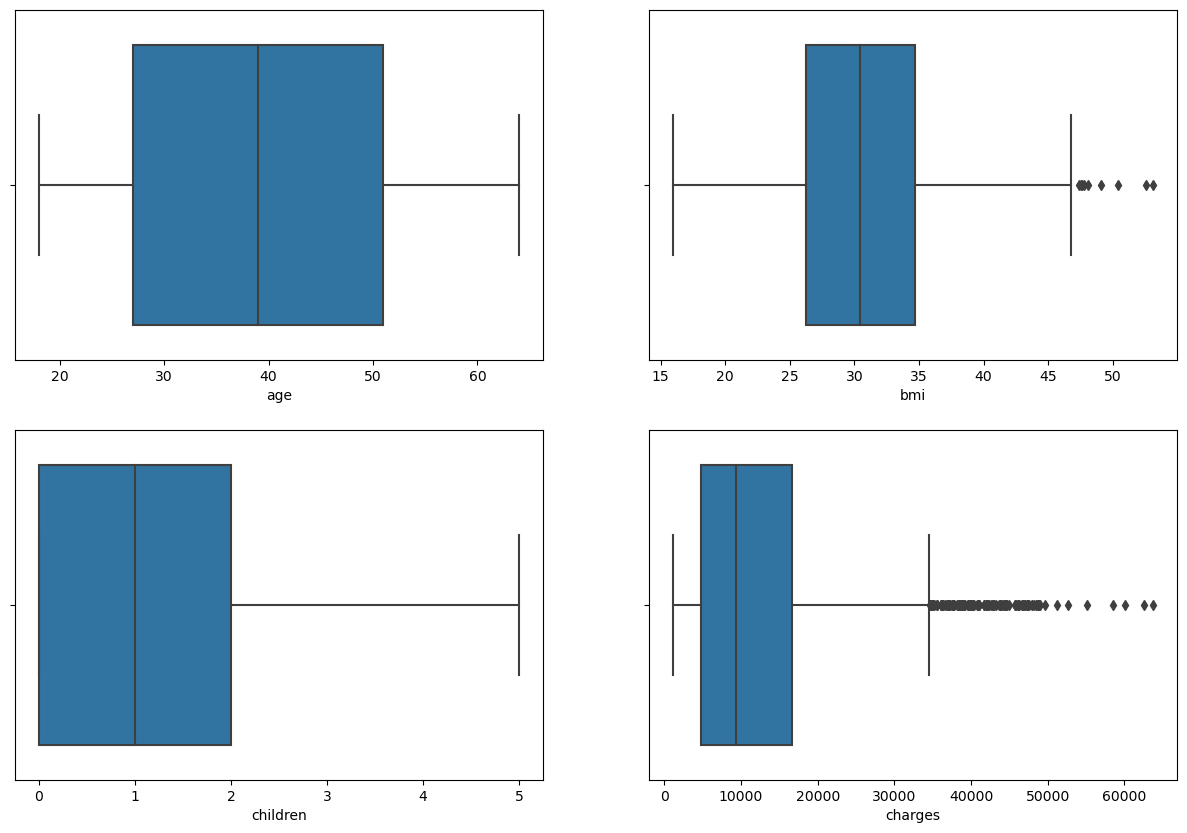

In [41]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
n = 0
for i in range(2):
    for j in range(2):
        sns.boxplot(
            data=data, 
            x = data[num[n]],
            ax=ax[i,j]
        )
        n+=1


Con el diagrama realizado se puede observar que se presentan outliers en  las variables numericas 'bmi' y 'charges, por lo cual procedemos a indicarlos

In [23]:
def detect_otliers(df, x):
    Q3 = df[x].quantile(0.75)
    Q1 = df[x].quantile(0.25)
    IQR = Q3 - Q1
    superior = Q3 + (1.5 * IQR)
    inferior = Q1 - (1.5 * IQR)
    out_sup = df[df[x] > superior].index
    out_inf = df[df[x] < inferior].index
    outliers = []
    for i in out_sup:
        outliers.append(i)
        for j in out_inf:
            outliers.append(j)
    
    size = len(outliers)
    print(f'Hay {size} outliers en la variable {x},y corresponden a los indices: {outliers} \n')
    return outliers

In [34]:
bmi_outlier = detect_otliers(data, 'bmi')
charges_outlier = detect_otliers(data, 'charges')

print('outliers que estan interrelacionados', list(set(bmi_outlier)&set(charges_outlier)))

Hay 9 outliers en la variable bmi,y corresponden a los indices: [116, 286, 401, 543, 847, 860, 1047, 1088, 1317] 

Hay 139 outliers en la variable charges,y corresponden a los indices: [14, 19, 23, 29, 30, 34, 38, 39, 49, 53, 55, 82, 84, 86, 94, 109, 123, 146, 158, 161, 175, 185, 203, 223, 240, 242, 251, 252, 254, 256, 263, 265, 271, 281, 288, 292, 298, 312, 314, 322, 327, 328, 330, 338, 373, 377, 381, 420, 421, 422, 441, 476, 488, 500, 524, 530, 543, 549, 558, 569, 577, 587, 609, 615, 621, 623, 629, 665, 667, 668, 674, 677, 682, 689, 697, 706, 725, 736, 738, 739, 742, 759, 803, 819, 826, 828, 842, 845, 850, 852, 856, 860, 883, 893, 901, 917, 947, 951, 953, 956, 958, 1012, 1021, 1022, 1031, 1036, 1037, 1047, 1049, 1062, 1070, 1078, 1090, 1096, 1111, 1117, 1118, 1122, 1124, 1139, 1146, 1152, 1156, 1186, 1206, 1207, 1218, 1230, 1240, 1241, 1249, 1284, 1288, 1291, 1300, 1301, 1303, 1313, 1323] 

outliers que estan interrelacionados [860, 543, 1047]


<AxesSubplot: >

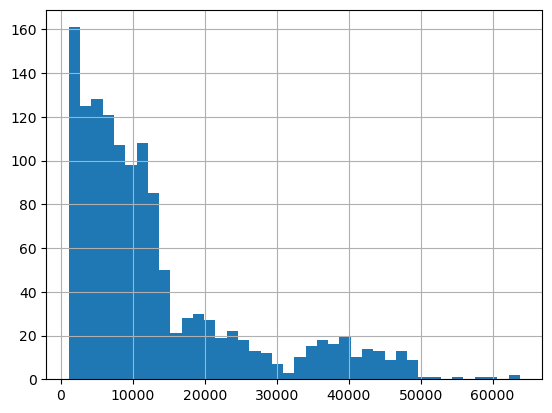

In [42]:
data.charges.hist(bins=40)

Con este histograma de los 'charges' podemos ver que después de los 50000 hay pocos valores, y por el boxplot hecho anteriormente sabemos que son outliers por lo  cual procedemos a remover estos valores superiores para mejorar el rendimiento del modelo

In [40]:
len(data[data['charges']>=50000])

7

En total se removeran 7 datos

In [43]:
data=data[data['charges']<=50000]

## Analisis de las correlaciones

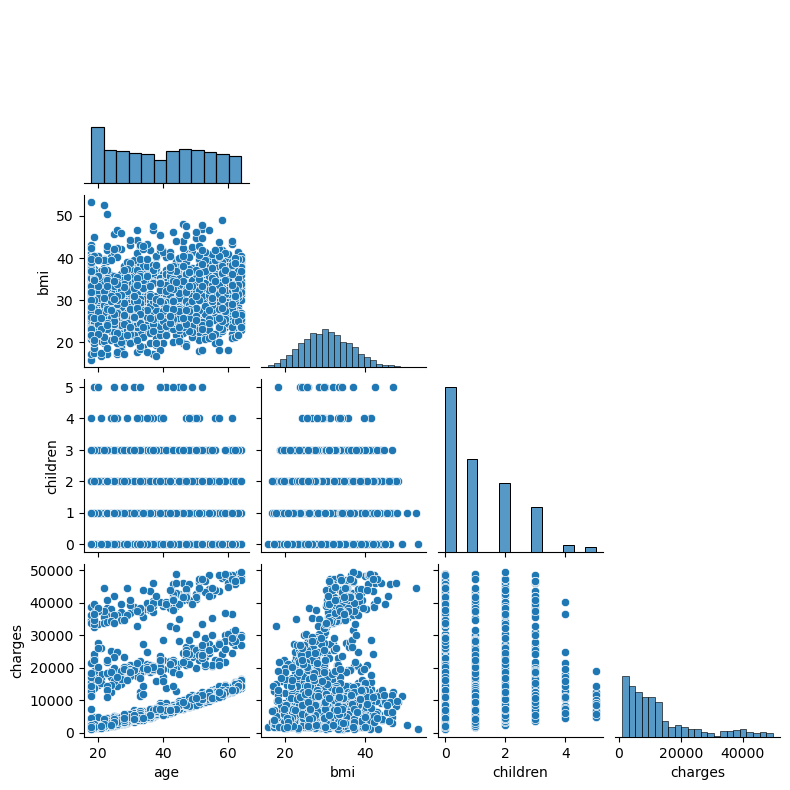

In [46]:
sns.pairplot(data, height=2, corner=True);

Procedemos a ver la matriz de correlación con un mapa de calor 

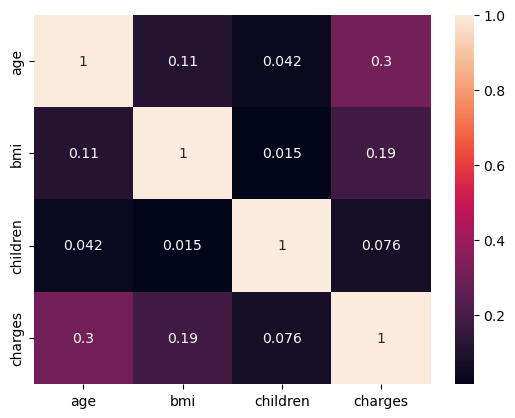

In [47]:
sns.heatmap(
    data.corr(numeric_only = True),
    annot=True,
);

Se puede observar que no las variables no estan interrelacionadas entre si

### One Hot encoding
Para las tres variables categoricas se procede a hacer una codificación para que se pueda representar en números y así usar el modelo de regresión lineal

In [39]:
for c in cat: 
    print(data[c].unique())

['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


In [48]:
data['sex'].replace(to_replace=['female', 'male'], value=[0,1], inplace=True)
data['smoker'].replace(to_replace=['yes', 'no'], value=[1,0], inplace=True)

In [49]:
data=pd.get_dummies(data)

Revisamos otras ver las correlaciones

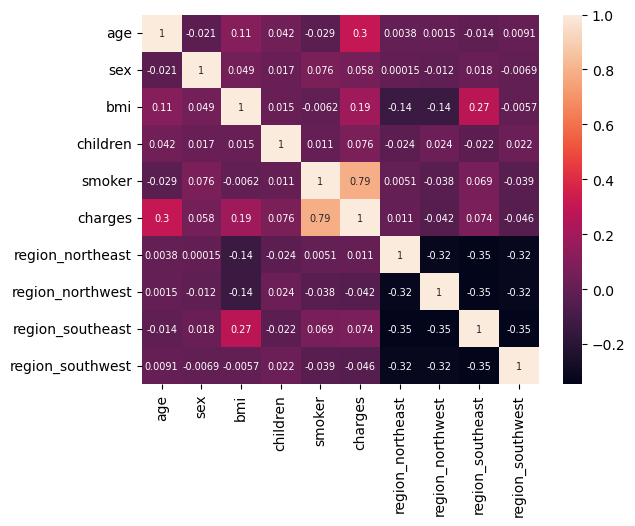

In [55]:
sns.heatmap(
    data.corr(numeric_only = True),
    annot=True,
    annot_kws={'size':7}
);

Ahora con todas las variables númericos podemos concluir que hay una alta correlacion entre el 'charge' y ser fumador

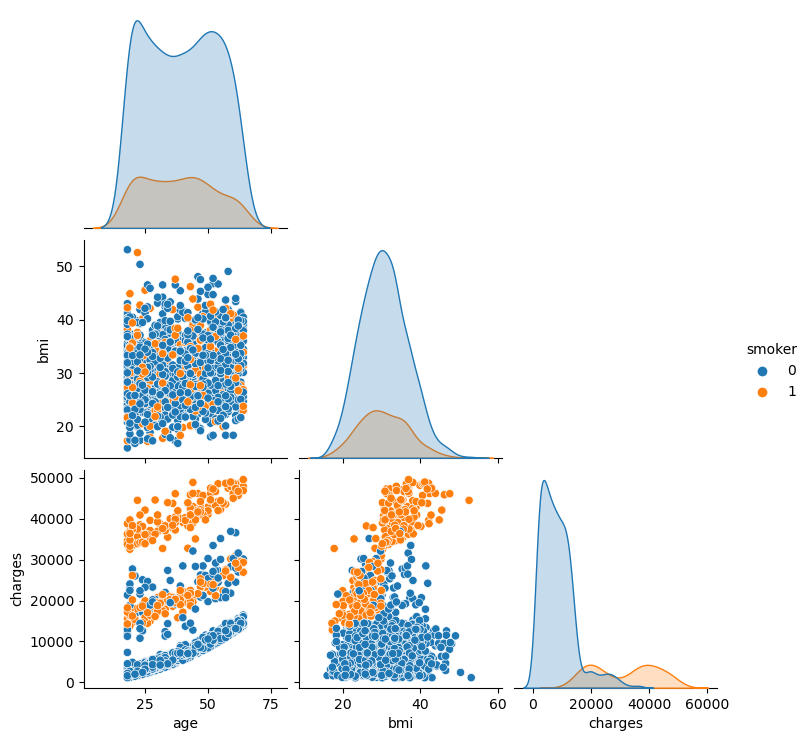

In [57]:
cols=['age', 'bmi', 'charges', 'smoker']
sns.pairplot(data[cols], corner=True, hue='smoker');

## Modelo
Para mejorar el modelo agregaremos o modificaremos caracteristicas

In [59]:
data['age'] = data.age ** 2
data['overweight'] = (data.bmi >= 30).astype(int)
data['OW_and_Smoke'] = data.overweight * data.smoker

**Normalización de los datos**

In [69]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

In [70]:
data_scaled

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,overweight,OW_and_Smoke
0,-1.219931,-1.009064,-0.448866,-0.910496,1.995313,0.328304,-0.566352,-0.565194,-0.611528,1.765686,-1.052504,-0.340253
1,-1.252806,0.991018,0.515202,-0.081072,-0.501175,-0.967902,-0.566352,-0.565194,1.635247,-0.566352,0.950115,-0.340253
2,-0.844095,0.991018,0.388740,1.577778,-0.501175,-0.734993,-0.566352,-0.565194,1.635247,-0.566352,0.950115,-0.340253
3,-0.573102,0.991018,-1.302075,-0.910496,-0.501175,0.764343,-0.566352,1.769303,-0.611528,-0.566352,-1.052504,-0.340253
4,-0.630854,0.991018,-0.287915,-0.910496,-0.501175,-0.784809,-0.566352,1.769303,-0.611528,-0.566352,-1.052504,-0.340253
...,...,...,...,...,...,...,...,...,...,...,...,...
1325,0.680574,0.991018,0.055340,1.577778,-0.501175,-0.209043,-0.566352,1.769303,-0.611528,-0.566352,0.950115,-0.340253
1326,-1.252806,-1.009064,0.211364,-0.910496,-0.501175,-0.926823,1.765686,-0.565194,-0.611528,-0.566352,0.950115,-0.340253
1327,-1.252806,-1.009064,1.021050,-0.910496,-0.501175,-0.976087,-0.566352,-0.565194,1.635247,-0.566352,0.950115,-0.340253
1328,-1.148851,-1.009064,-0.793763,-0.910496,-0.501175,-0.943756,-0.566352,-0.565194,-0.611528,1.765686,-1.052504,-0.340253


Separamos la variable objetivo y hacer un split de los datos

In [71]:
X= data_scaled.drop('charges', axis=1)
y= data_scaled['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
model=LinearRegression().fit(X_train, y_train)
y_pred=model.predict(X_test)

### Evaluacion del modelo

In [80]:
print("MSE: %.2f" % mean_squared_error(y_test, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred))
print('R²: %.2f' % r2_score(y_test, y_pred))

MSE: 0.36
MAE: 0.19
R²: 0.87


Los coeficientes de regresión son

In [81]:
model.coef_

array([ 0.33303478, -0.02380599,  0.06548996,  0.08447617,  0.46102918,
        0.02300916,  0.01599956, -0.00957036, -0.02905832, -0.04104219,
        0.49099084])

In [82]:
model.intercept_

0.0022568772199714165

### Resumen del modelo

In [84]:
# Ajustar el modelo para ver el reporte
model_ = sm.OLS(y, X).fit() 
# Mostrar las estadísticas del modelo
model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.865
Method:                 Least Squares   F-statistic:                              854.7
Date:                Mon, 23 Jan 2023   Prob (F-statistic):                        0.00
Time:                        18:27:29   Log-Likelihood:                         -549.47
No. Observations:                1330   AIC:                                      1119.
Df Residuals:                    1320   BIC:                                      1171.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.3195      0.010     31.472      0.000       0.300       0.339
sex                 -0.0194      0.010     -1.916      0.056      -0.039       0.000
bmi                  0.0576      0.017      3.323      0.001       0.024       0.092
children             0.0706      0.010      7.005      0.000       0.051       0.090
smoker               0.4589      0.015     31.524      0.000       0.430       0.487
region_northeast     0.0217      0.008      2.826      0.005       0.007       0.037
region_northwest     0.0096      0.008      1.249      0.212      -0.005       0.025
region_southeast    -0.0082      0.008     -1.060      0.289      -0.023       0.007
region_southwest    -0.0228      0.008     -2.992      0.003      -0.038      -0.008
overweight          -0.0387      0.017     -2.213      0.027      -0.073      -0.004
OW_and_Smoke         0.4961      0.015     32.269      0.000       0.466       0.526
==============================================================================
Omnibus:                      909.771   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8560.037
Skew:                           3.248   Prob(JB):                         0.00
Kurtosis:                      13.595   Cond. No.                     4.02e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.87e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Las variables que tiene peso estadistico en el modelo son : 
* age
* bmi
* children
* smoker
* region_northwest
* region_southwest
* overweight
* OW_and_Smoke

Se puede observar que las tres variables que transformamos tiene una relación importante con el desempeño del modelo

## Exportar modelo

In [85]:
import joblib
joblib.dump(model, 'ModeloRegresion.joblib')

['ModeloRegresion.joblib']